# Detecting Twenty-thousand Classes using Image-level Supervision

<img align="center" src="https://github.com/facebookresearch/Detic/raw/main/docs/teaser.jpeg" width="800">

This is a colab demo of using Detic (A **Det**ector with **i**mage **c**lasses). We will use the pretrained Detic models to run object detection on both the detector's vocabulary and any user-specifid vocabulary.

This demo is modified from the [detectron2 colab tutorial](https://colab.research.google.com/drive/16jcaJoc6bCFAQ96jDe2HwtXj7BMD_-m5).

You can make a copy of this tutorial by "File -> Open in playground mode" and make changes there. __DO NOT__ request access to this tutorial.


In [1]:
# Install detectron2
import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html

torch:  1.10 ; cuda:  cu111
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.10/index.html
     |████████████████████████████████| 7.0 MB 899 kB/s 
     |████████████████████████████████| 130 kB 5.1 MB/s 
     |████████████████████████████████| 74 kB 3.0 MB/s 
     |████████████████████████████████| 145 kB 44.8 MB/s 
     |████████████████████████████████| 50 kB 6.7 MB/s 
     |████████████████████████████████| 749 kB 47.7 MB/s 
     |████████████████████████████████| 843 kB 38.9 MB/s 
     |████████████████████████████████| 596 kB 47.5 MB/s 
     |████████████████████████████████| 112 kB 48.0 MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.5.post20220305-py3-none-any.whl size=61214 sha256=632f0418a47df2ce06800f53ff02fc93343575144e2135f51f7cba607e03e497
  Stored in directory: /root/.cache/pip/wheels/b5/b7/6e/43b1693d06fac3633af48db68557513b0a37ab38b0a8b798f9
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.8-py3-none-any

In [2]:
# clone and install Detic
!git clone https://github.com/facebookresearch/Detic.git --recurse-submodules
%cd Detic
!pip install -r requirements.txt

Cloning into 'Detic'...
remote: Enumerating objects: 162, done.
remote: Counting objects: 100% (86/86), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 162 (delta 30), reused 68 (delta 26), pack-reused 76
Receiving objects: 100% (162/162), 3.57 MiB | 16.27 MiB/s, done.
Resolving deltas: 100% (43/43), done.
Submodule 'third_party/CenterNet2' (https://github.com/xingyizhou/CenterNet2.git) registered for path 'third_party/CenterNet2'
Submodule 'third_party/Deformable-DETR' (https://github.com/fundamentalvision/Deformable-DETR.git) registered for path 'third_party/Deformable-DETR'
Cloning into '/content/Detic/third_party/CenterNet2'...
remote: Enumerating objects: 13896, done.        
remote: Counting objects: 100% (3008/3008), done.        
remote: Compressing objects: 100% (1295/1295), done.        
remote: Total 13896 (delta 1994), reused 2429 (delta 1695), pack-reused 10888        
Receiving objects: 100% (13896/13896), 5.70 MiB | 17.90 MiB/s, done.
Resolving delta

In [3]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import sys
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# Detic libraries
sys.path.insert(0, 'third_party/CenterNet2/projects/CenterNet2/')
from centernet.config import add_centernet_config
from detic.config import add_detic_config
from detic.modeling.utils import reset_cls_test

In [4]:
# Build the detector and download our pretrained weights
cfg = get_cfg()
add_centernet_config(cfg)
add_detic_config(cfg)
cfg.merge_from_file("configs/Detic_LCOCOI21k_CLIP_SwinB_896b32_4x_ft4x_max-size.yaml")
cfg.MODEL.WEIGHTS = 'https://dl.fbaipublicfiles.com/detic/Detic_LCOCOI21k_CLIP_SwinB_896b32_4x_ft4x_max-size.pth'
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
cfg.MODEL.ROI_BOX_HEAD.ZEROSHOT_WEIGHT_PATH = 'rand'
cfg.MODEL.ROI_HEADS.ONE_CLASS_PER_PROPOSAL = True # For better visualization purpose. Set to False for all classes.
# cfg.MODEL.DEVICE='cpu' # uncomment this to use cpu-only mode.
predictor = DefaultPredictor(cfg)

/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Detic_LCOCOI21k_CLIP_SwinB_896b32_4x_ft4x_max-size.pth: 702MB [00:16, 43.3MB/s]                           


In [6]:
# Setup the model's vocabulary using build-in datasets

BUILDIN_CLASSIFIER = {
    'lvis': 'datasets/metadata/lvis_v1_clip_a+cname.npy',
    'objects365': 'datasets/metadata/o365_clip_a+cnamefix.npy',
    'openimages': 'datasets/metadata/oid_clip_a+cname.npy',
    'coco': 'datasets/metadata/coco_clip_a+cname.npy',
}

BUILDIN_METADATA_PATH = {
    'lvis': 'lvis_v1_val',
    'objects365': 'objects365_v2_val',
    'openimages': 'oid_val_expanded',
    'coco': 'coco_2017_val',
}

vocabulary = 'lvis' # change to 'lvis', 'objects365', 'openimages', or 'coco'
metadata = MetadataCatalog.get(BUILDIN_METADATA_PATH[vocabulary])
classifier = BUILDIN_CLASSIFIER[vocabulary]
num_classes = len(metadata.thing_classes)
reset_cls_test(predictor.model, classifier, num_classes)

Resetting zs_weight datasets/metadata/lvis_v1_clip_a+cname.npy


--2022-03-23 08:58:03--  https://web.eecs.umich.edu/~fouhey/fun/desk/desk.jpg
Resolving web.eecs.umich.edu (web.eecs.umich.edu)... 141.212.113.214
Connecting to web.eecs.umich.edu (web.eecs.umich.edu)|141.212.113.214|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 289506 (283K) [image/jpeg]
Saving to: ‘desk.jpg’

desk.jpg            100%[===================>] 282.72K  --.-KB/s    in 0.07s   

2022-03-23 08:58:03 (3.80 MB/s) - ‘desk.jpg’ saved [289506/289506]



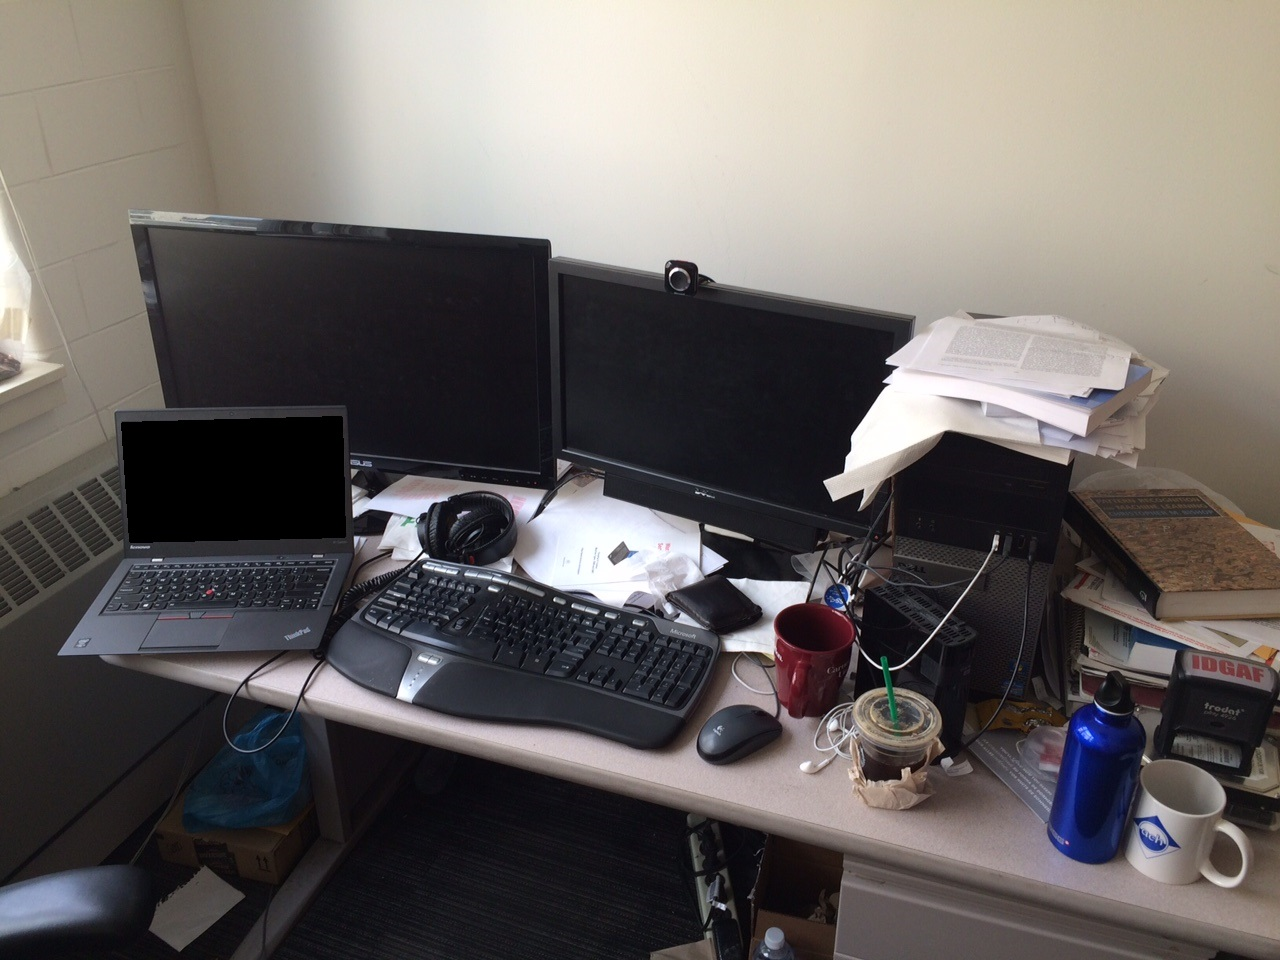

In [7]:
# Download a sample image and display. Replace path here to try your own images!
!wget https://web.eecs.umich.edu/~fouhey/fun/desk/desk.jpg
im = cv2.imread("./desk.jpg")
cv2_imshow(im)

/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


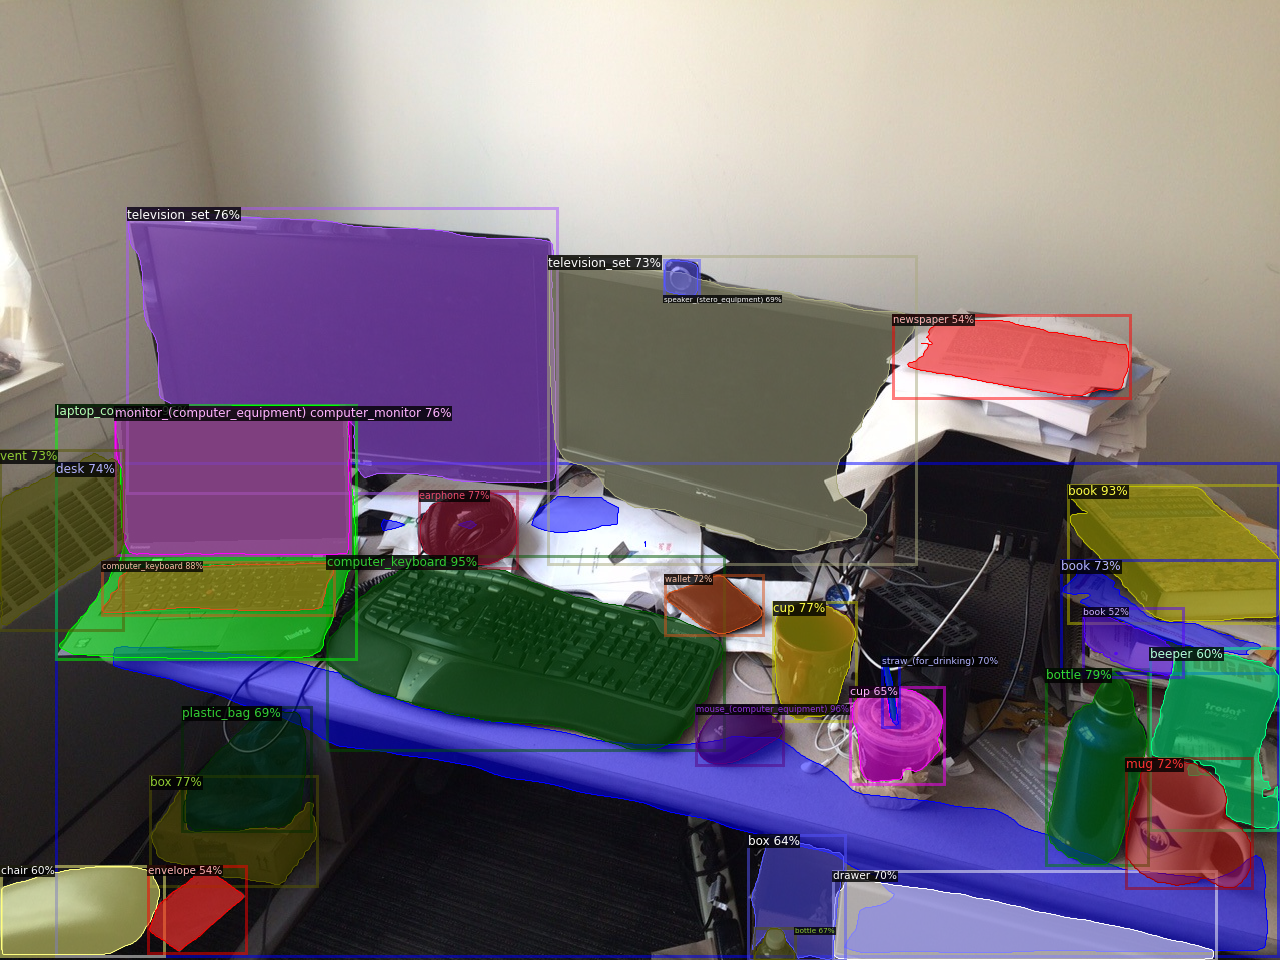

In [8]:
# Run model and show results
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1], metadata)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

In [9]:
# Change the model's vocabulary to a customized one and get their word-embedding 
#  using a pre-trained CLIP model.

from detic.modeling.text.text_encoder import build_text_encoder
def get_clip_embeddings(vocabulary, prompt='a '):
    text_encoder = build_text_encoder(pretrain=True)
    text_encoder.eval()
    texts = [prompt + x for x in vocabulary]
    emb = text_encoder(texts).detach().permute(1, 0).contiguous().cpu()
    return emb
  
vocabulary = 'custom'
metadata = MetadataCatalog.get("__unused")
metadata.thing_classes = ['headphone', 'webcam', 'paper', 'coffee'] # Change here to try your own vocabularies!
classifier = get_clip_embeddings(metadata.thing_classes)
num_classes = len(metadata.thing_classes)
reset_cls_test(predictor.model, classifier, num_classes)
# Reset visualization threshold
output_score_threshold = 0.3
for cascade_stages in range(len(predictor.model.roi_heads.box_predictor)):
    predictor.model.roi_heads.box_predictor[cascade_stages].test_score_thresh = output_score_threshold

100%|███████████████████████████████████████| 338M/338M [00:05<00:00, 64.5MiB/s]


Loading pretrained CLIP


/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


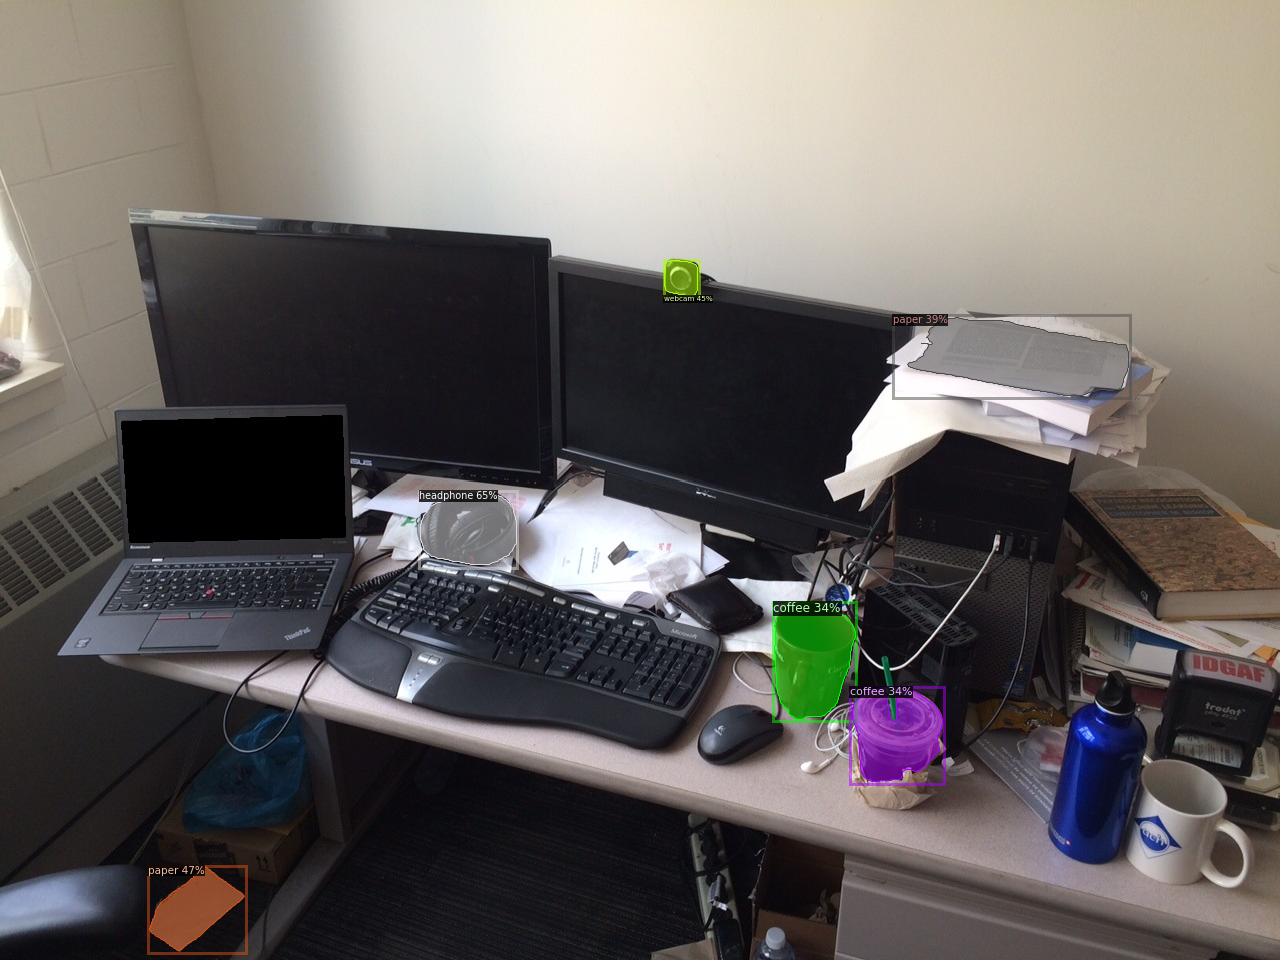

In [13]:
# Run model and show results
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1], metadata)
# v = Visualizer(im[:, :, ::1], metadata)

out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

In [14]:
v

In [15]:
outputs["instances"]

Instances(num_instances=6, image_height=960, image_width=1280, fields=[pred_boxes: Boxes(tensor([[ 419.1836,  491.0833,  517.4153,  567.7354],
        [ 147.8862,  865.7650,  245.6065,  952.5587],
        [ 663.5050,  259.6931,  698.9725,  296.0034],
        [ 892.8220,  314.8460, 1129.9359,  398.4209],
        [ 850.0912,  686.8865,  943.6356,  783.7984],
        [ 773.4059,  602.2183,  856.4293,  720.5630]], device='cuda:0')), scores: tensor([0.6491, 0.4727, 0.4451, 0.3891, 0.3375, 0.3370], device='cuda:0'), pred_classes: tensor([0, 2, 1, 2, 3, 3], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False,

/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


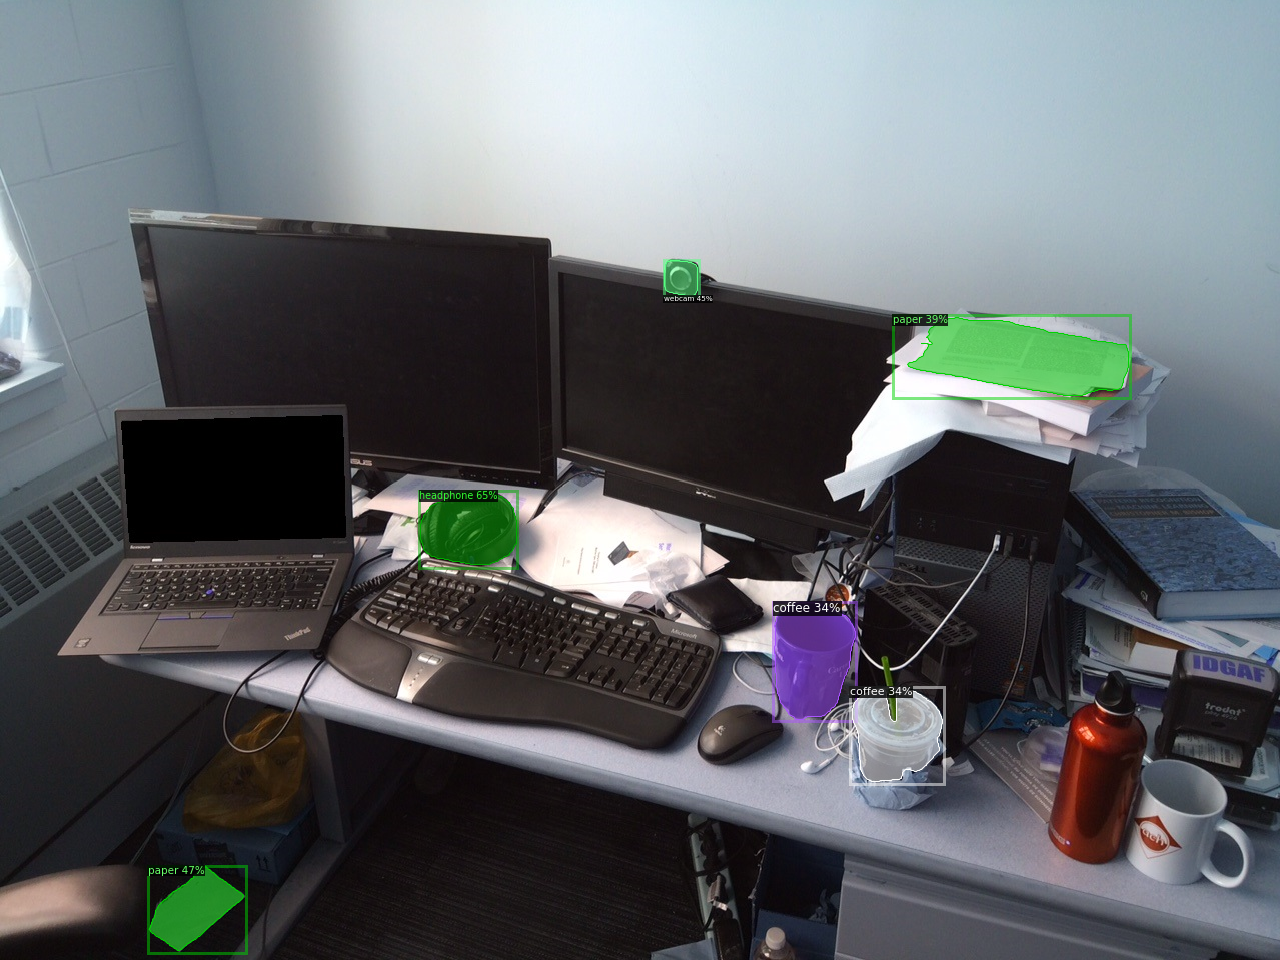

In [16]:
# Run model and show results
outputs = predictor(im)
# v = Visualizer(im[:, :, ::-1], metadata)
v = Visualizer(im[:, :, ::1], metadata)

out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


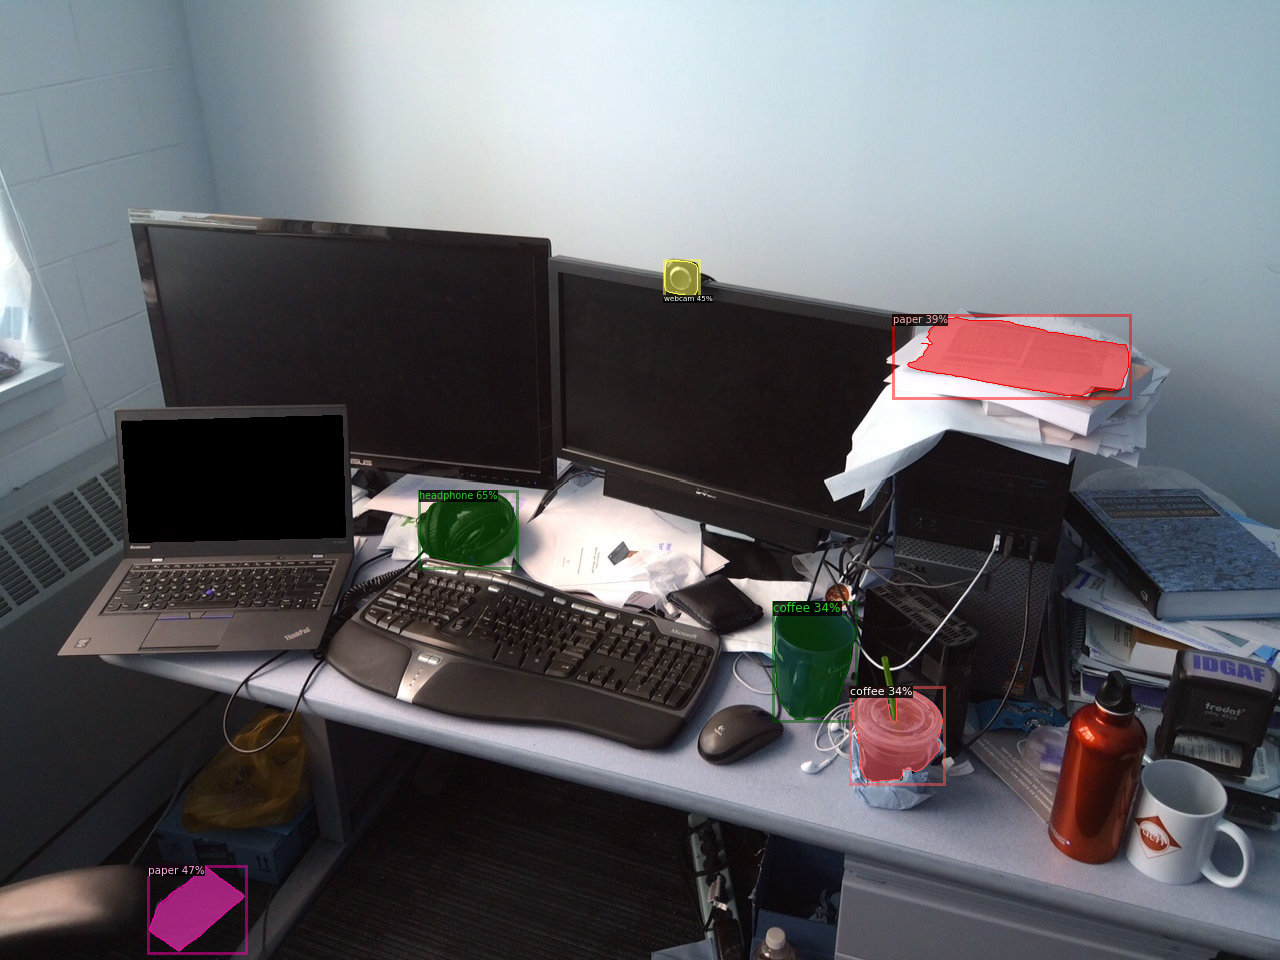

In [17]:
# Run model and show results
outputs = predictor(im)
# v = Visualizer(im[:, :, ::-1], metadata)
v = Visualizer(im[:, :, ::-1], metadata)

out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::1])

In [18]:
# look at the outputs. 
# See https://detectron2.readthedocs.io/tutorials/models.html#model-output-format for specification
print(outputs["instances"].pred_classes) # class index
print([metadata.thing_classes[x] for x in outputs["instances"].pred_classes.cpu().tolist()]) # class names
print(outputs["instances"].scores)
print(outputs["instances"].pred_boxes)

tensor([0, 2, 1, 2, 3, 3], device='cuda:0')
['headphone', 'paper', 'webcam', 'paper', 'coffee', 'coffee']
tensor([0.6491, 0.4727, 0.4451, 0.3891, 0.3375, 0.3370], device='cuda:0')
Boxes(tensor([[ 419.1836,  491.0833,  517.4153,  567.7354],
        [ 147.8862,  865.7650,  245.6065,  952.5587],
        [ 663.5050,  259.6931,  698.9725,  296.0034],
        [ 892.8220,  314.8460, 1129.9359,  398.4209],
        [ 850.0912,  686.8865,  943.6356,  783.7984],
        [ 773.4059,  602.2183,  856.4293,  720.5630]], device='cuda:0'))
